Run these commands into the terminal
```
pip install qiskit[visualization]
pip install qiskit-ibm-runtime
```

In [14]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [15]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", instance="rpi-rensselaer/general/general")
backend = service.backend('ibm_rensselaer')

In [16]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

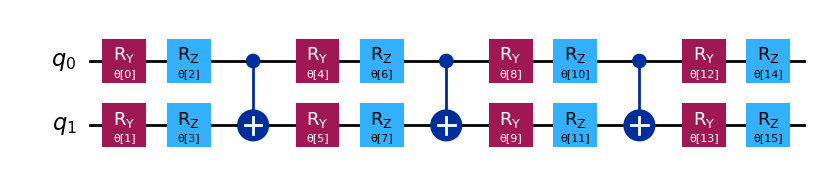

In [17]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [18]:
num_params = ansatz.num_parameters
num_params

16

In [19]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

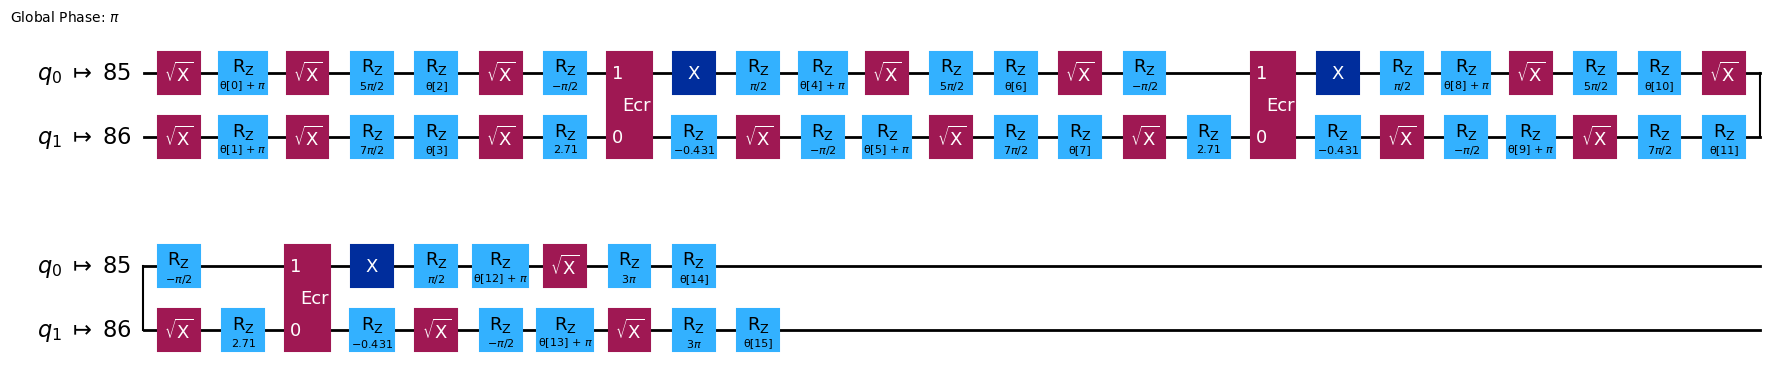

In [20]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [21]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [22]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [23]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [24]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([4.34104384, 2.94763361, 5.28796378, 4.58321847, 4.91353512,
       1.52328952, 4.5670078 , 3.75253748, 0.07459039, 4.31536841,
       5.94313096, 3.61754384, 4.35601537, 5.6923119 , 1.71367989,
       5.84509971])

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )
# 73 mins 8 secs

NameError: name 'Session' is not defined

In [15]:
res

NameError: name 'res' is not defined

In [16]:
all(cost_history_dict["prev_vector"] == res.x)

NameError: name 'res' is not defined

In [ ]:
cost_history_dict["iters"] == res.nfev

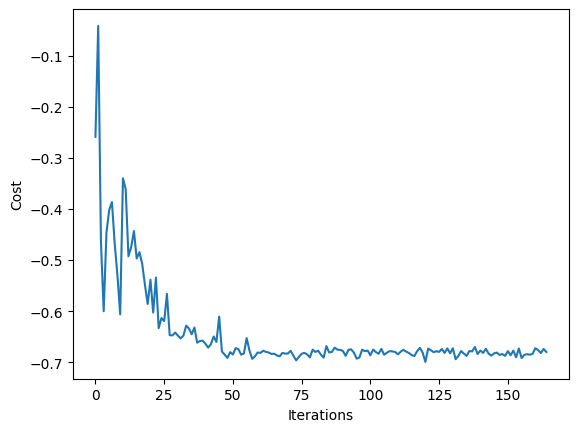

In [26]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()